In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn.cross_validation import train_test_split
# Each is a different implementation of a text transform tool: Bag of Words & Tfidf
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
rows = []
with open('/Users/benstan/Desktop/GA-DS/SF-DAT-20-MASTER/Data/amazon_cells_labelled.txt') as f:
    for i,line in enumerate(f.readlines()):
        row = (line.split('\n')[0]).split('\t')
        if row[1] == '':
            row[1] = np.nan
        else:
            row[1] = int(row[1])
        rows.append(row)

In [3]:
Amazon_data = pd.DataFrame(rows,columns=['text','sentiment'])
Amazon_data.head()

,text,sentiment
0,I try not to adjust the volume setting to avoi...,NaN
1,So there is no way for me to plug it in here i...,0
2,"Good case, Excellent value.",1
3,I thought Motorola made reliable products!.,NaN
4,Battery for Motorola Razr.,NaN


In [4]:
Amazon_data.dropna(inplace = True)
Amazon_data.head()

,text,sentiment
1,So there is no way for me to plug it in here i...,0
2,"Good case, Excellent value.",1
5,Great for the jawbone.,1
10,Tied to charger for conversations lasting more...,0
11,The mic is great.,1


The data is sentiment on Amazon reviews! But in order to use it we need to create a feature space. Please review the documentation for these functions: 

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
You'll see that we have a ton of options available. I'll start out with the simplest default.

In [5]:
count_vect = CountVectorizer(stop_words='english')
bag_o_words = count_vect.fit_transform(Amazon_data['text'])
bag_o_words

<1000x1642 sparse matrix of type '<type 'numpy.int64'>'
	with 4702 stored elements in Compressed Sparse Row format>

Dense matrices store every entry in the matrix. Sparse matrices only store the nonzero entries. Sparse matrices don't have a lot of extra features, and some algorithms may not work for them. You use them when you need to work with matrices that would be too big for the computer to handle them, but they are mostly zero, so they compress easily. You can convert to dense matrices with .todense( )

In [6]:
# bag_o_words.todense()
count_vect.get_feature_names()

[u'10',
 u'100',
 u'11',
 u'12',
 u'13',
 u'15',
 u'15g',
 u'18',
 u'20',
 u'2000',
 u'2005',
 u'2160',
 u'24',
 u'2mp',
 u'325',
 u'350',
 u'375',
 u'3o',
 u'42',
 u'44',
 u'45',
 u'4s',
 u'50',
 u'5020',
 u'510',
 u'5320',
 u'680',
 u'700w',
 u'8125',
 u'8525',
 u'8530',
 u'abhor',
 u'ability',
 u'able',
 u'abound',
 u'absolutel',
 u'absolutely',
 u'ac',
 u'accept',
 u'acceptable',
 u'access',
 u'accessable',
 u'accessing',
 u'accessory',
 u'accessoryone',
 u'accidentally',
 u'accompanied',
 u'according',
 u'activate',
 u'activated',
 u'activesync',
 u'actually',
 u'ad',
 u'adapter',
 u'adapters',
 u'add',
 u'addition',
 u'additional',
 u'address',
 u'adhesive',
 u'adorable',
 u'advertised',
 u'advise',
 u'aggravating',
 u'ago',
 u'alarm',
 u'allot',
 u'allow',
 u'allowing',
 u'allows',
 u'alot',
 u'aluminum',
 u'amazed',
 u'amazing',
 u'amazon',
 u'amp',
 u'ample',
 u'angeles',
 u'angle',
 u'answer',
 u'ant',
 u'antena',
 u'anti',
 u'apart',
 u'apartment',
 u'apparently',
 u'appeali

    CV_SCORE  Number of Features
0      0.728                  10
1      0.746                  20
2      0.756                  50
3      0.759                  70
4      0.760                  80
5      0.762                  90
6      0.766                 100
7      0.764                 150
8      0.766                 200
9      0.760                 300
10     0.760                 400
11     0.759                 500
12     0.759                 600
13     0.759                 700
14     0.758                1000


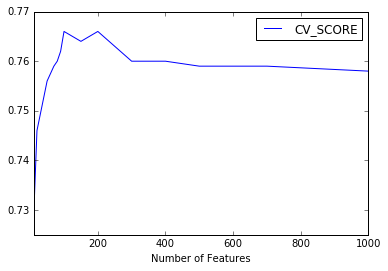

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
X = bag_o_words
y = Amazon_data['sentiment']
features = [10,20,50,70,80,90,100,150,200,300,400,500,600,700,1000]
scores_cv = []
for i in features:
    RF = RandomForestClassifier(n_estimators = 1000, #Number of trees - the more the better!
                           max_features = i,     #How many features to randomly choose in each node 
                           min_samples_leaf = 5, #Minimum number of observations at each terminal node
                           oob_score = True)
    RF.fit(X,y)
    scores = cross_val_score(RF,X,y,cv=5)
    scores_cv.append(scores.mean())

num_features_df = pd.DataFrame({'CV_SCORE': scores_cv ,'Number of Features': features})
print num_features_df
num_features_df.plot(x='Number of Features', y='CV_SCORE')

100 features looks like the best option

# GridSearchCV and Pipeline Great tools that all data scientists enjoy using!

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
# Resetting our data
X_train,X_test,y_train,y_test = train_test_split(Amazon_data['text'],Amazon_data['sentiment'],test_size=0.2)

In [10]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('clf', RandomForestClassifier())])

You can set both parameters of your classification algorithm and parameters of CountVectorizer(). Couple of points to remember:

1. You cannot use parameters that contradict each other. For example if min and max do not match you will see an error.
2. It is harder to find out contradiction of two different parameters. For example if you set maximum_feature (number of random features to use) in random forest to 50 but max_df in vect is 30, then you will have an error.
3. It seems like for classification problems, you can only use algorithms that work with probability. If your algorithm works with Loss functions then you cannot use GridSearchCV. Particularly, it seems like Gradiant Boosting Trees cannot be used in GridSearchCV. A few algorithms that can be used in GridSearchCV are: logistic regression,  random forest and Naive Bayes. 

In [11]:
parameters = {'vect__min_df':[1,2,3],
              'vect__max_df':[5,10,100,200,500,1000],
              'clf__n_estimators':[1000]}

gs_clf = GridSearchCV(text_clf, parameters) #, n_jobs=1)

In [12]:
fit_grid = gs_clf.fit(X_train,y_train)

In [13]:
fit_grid.score(X_test,y_test)

0.78000000000000003

In [14]:
fit_grid.best_params_

{'clf__n_estimators': 1000, 'vect__max_df': 1000, 'vect__min_df': 1}

#### Now let's try TfidVectorizer

In [15]:
text_clf = Pipeline([('vect', TfidfVectorizer()),
                     ('clf', RandomForestClassifier()) ])

parameters = {'vect__min_df':[1,5,10],
              'vect__max_df':[15,50,100,200,500,1000],
              'clf__n_estimators':[1000]}

gs_clf = GridSearchCV(text_clf, parameters)

In [17]:
fit_grid = gs_clf.fit(X_train,y_train)

In [18]:
fit_grid.score(X_test,y_test)

0.78500000000000003

In [19]:
fit_grid.best_params_

{'clf__n_estimators': 1000, 'vect__max_df': 100, 'vect__min_df': 1}